In [2]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report,make_scorer,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split,GridSearchCV # Import train_test_split function

#for visualization
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.utils import resample

import warnings
warnings.simplefilter('ignore')

from joblib import dump, load


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [0]:
! mkdir /content/data
!cp clean_dataset_v2.csv /content/data

In [3]:
df = pd.read_csv('data/clean_dataset_v2.csv')
df.head()

,funding_total_usd,funding_rounds,total_investors,funding_duration,pseudoEstd,angel,convertible_note,debt_financing,equity_crowdfunding,grant,non_equity_assistance,private_equity,product_crowdfunding,secondary_market,seed,undisclosed,venture,A,B,C,D,E,F,G,H,success,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,...,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,5.845098,2,0.0,7.0,649.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.316785,1,1.0,0.0,654.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.526339,4,14.0,34.0,636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.060717,3,13.0,30.0,618.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.957633,1,0.0,0.0,639.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
labels = df['success'].astype(int)
features = df.drop(['success'],axis=1)
features

,funding_total_usd,funding_rounds,total_investors,funding_duration,pseudoEstd,angel,convertible_note,debt_financing,equity_crowdfunding,grant,non_equity_assistance,private_equity,product_crowdfunding,secondary_market,seed,undisclosed,venture,A,B,C,D,E,F,G,H,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,...,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
0,5.845098,2,0.0,7.0,649.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.316785,1,1.0,0.0,654.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7.526339,4,14.0,34.0,636.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.060717,3,13.0,30.0,618.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.957633,1,0.0,0.0,639.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37596,6.518514,2,11.0,6.0,662.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37597,6.332438,2,2.0,2.0,642.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37598,6.179121,4,2.0,23.0,609.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37599,6.929419,1,7.0,0.0,539.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Stratified train-test split

**Since our data is imbalanced, simple and random train-test split may divide the data in different ratio introducing bias in the dataset. So, we used stratified train-test split so that the ratio of data will be maintained.** 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.2,
                                                    stratify = labels,random_state=1,)

**We have splitted the data in 80-20% where the training data is further splitted in acutal training and validation dataset. 10% from the training dataset is separated as validation dataset.**

**Since we are using grid search cv for hyper parameter tuning, we have used predefined split which has a validation dataset in the same ratio as the test dataset. The balancing technique will be only applied in the train dataset and will check how it performs on the imbalanced validation dataset. This will reflect the true performaance for unseen test data.**

In [0]:
from sklearn.model_selection import PredefinedSplit
y_trInd, y_valInd = train_test_split(y_train.index, test_size=0.1,
                                           stratify =  y_train, random_state=1) 
split = y_train.copy()
split[y_trInd] = -1
split[y_valInd] = 0
val_split = PredefinedSplit(test_fold=split)
X_tr,X_val, y_tr, y_val = X_train[X_train.index.isin(y_trInd)], \
                          X_train[X_train.index.isin(y_valInd)], \
                          y_train[y_train.index.isin(y_trInd)],\
                          y_train[y_train.index.isin(y_valInd)]

In [7]:
val_split

PredefinedSplit(test_fold=array([-1, -1, ...,  0, -1]))

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=6)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
XTrain, yTrain = ros.fit_resample(X_train,y_train)

In [9]:
X_resampled.shape

(46562, 129)

In [0]:
#preparation of training dataset after balancing
X_combined = np.vstack([X_resampled, X_val])
y_combined = np.hstack([y_resampled,y_val])
split=np.concatenate([np.ones_like(y_resampled)*-1, np.zeros_like(y_val)])
val_split_balanced = PredefinedSplit(test_fold=split)


## Decision Tree

In [45]:
params = {
    'max_depth':np.arange(8,20),
    'max_features':[0.7,0.8,0.9,1.0],
    'min_samples_leaf':[3,4,5,7,8,9,10]
    #'criterion':['gini','entropy']
}
print("CLASS WEIGHT = ratio")
dtModelCW = DecisionTreeClassifier(criterion='gini',class_weight=None,random_state=1)
gridSearchCW = GridSearchCV(dtModelCW, params, cv=val_split_balanced, verbose=1, n_jobs=-1,scoring='roc_auc')
gridSearchCW.fit(X_combined, y_combined)
print(gridSearchCW.best_estimator_)
print('\n')


CLASS WEIGHT = ratio
Fitting 1 folds for each of 336 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:  2.0min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=0.7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')




In [0]:
!mkdir model

In [46]:
dtModel = gridSearchCW.best_estimator_

#dump(dtModel, './model/decisionTreeModel.joblib')
gridSearchCW.best_score_

0.821482251381152

In [47]:
y_predCW = dtModel.predict(X_test)
accuracyCW = accuracy_score(y_test,y_predCW)
print("The accuracy for decision tree",accuracyCW)
print("The macro f1 score for decision tree",f1_score(y_test,y_predCW,average='macro'))


The accuracy for decision tree 0.7606701236537694
The macro f1 score for decision tree 0.65153452685422


In [0]:
dot_data = StringIO()
export_graphviz(dtModel, out_file=dot_data,filled=True, rounded=True,
                special_characters=True,feature_names = features.columns.values,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('CompanySuccess_dtmodelCW.png')
Image(graph.create_png())

In [0]:
impFeatures = dtModel.feature_importances_
indices = np.argsort(-1*impFeatures)
sortedValue = impFeatures[indices]
sortedFeatures = features.columns.values[indices]


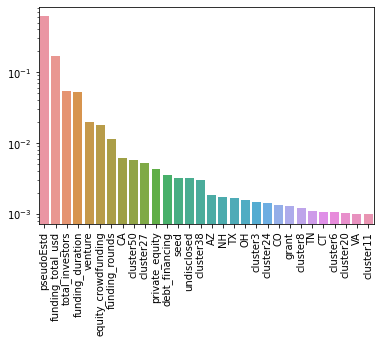

In [49]:
sns.barplot(x=sortedFeatures[:30], y=sortedValue[:30])
plt.xticks(rotation=90)
plt.yscale('log')


Confusion matrix for  decision tree


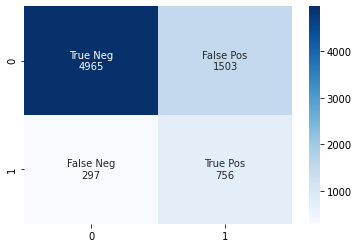

In [50]:
print('\nConfusion matrix for  decision tree')
#print(confusion_matrix(y_test, y_predCW))
cnf_matrix = confusion_matrix(y_test, y_predCW)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')


In [51]:
print('Classification Report for  decision tree')
reportCW = classification_report(y_test,y_predCW)
print(reportCW)

Classification Report for  decision tree
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      6468
           1       0.33      0.72      0.46      1053

    accuracy                           0.76      7521
   macro avg       0.64      0.74      0.65      7521
weighted avg       0.86      0.76      0.79      7521



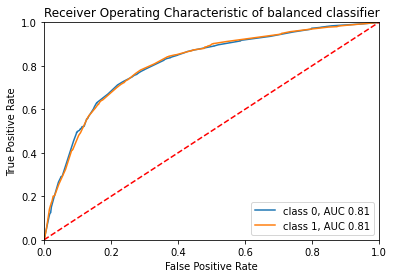

In [52]:
probs = dtModel.predict_proba(X_test)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
params = {
    'max_depth':[22, 25, 27],
    'max_features':[0.8,0.9,1],
    'n_estimators':[125, 150]
}

rfClassifier = RandomForestClassifier(n_jobs=-1,class_weight=None)
gridSearch = GridSearchCV(rfClassifier, params,verbose=1,n_jobs=-1,cv=val_split_balanced,scoring='roc_auc')
gridSearch.fit(X_combined, y_combined)
print(gridSearch.best_estimator_)

Fitting 1 folds for each of 18 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features=0.8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [55]:
rfModel = gridSearch.best_estimator_
gridSearch.best_score_
#dump(rfModel, './model/randomForestModel.joblib')

0.8294771867743614

In [56]:
rfTestPredict = rfModel.predict(X_test)
testScore = accuracy_score(y_test, rfTestPredict)
print("the accuracy score for testing set : {}".format(testScore))
print("The macro f1 score for random forest",f1_score(y_test,rfTestPredict,average='macro'))


the accuracy score for testing set : 0.8337986969817843
The macro f1 score for random forest 0.6886716311861332



Confusion matrix for  rf classifier


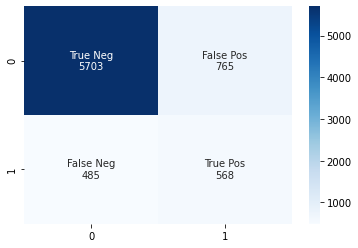

In [57]:
cnf_matrix = confusion_matrix(y_test, rfTestPredict)
print('\nConfusion matrix for  rf classifier')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')


In [58]:
print('Classification Report for rf class')
rfReport = classification_report(y_test,rfTestPredict)
print(rfReport)

Classification Report for rf class
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      6468
           1       0.43      0.54      0.48      1053

    accuracy                           0.83      7521
   macro avg       0.67      0.71      0.69      7521
weighted avg       0.85      0.83      0.84      7521



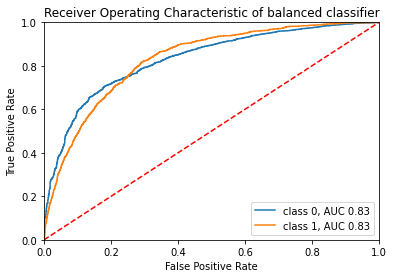

In [59]:
probs = rfModel.predict_proba(X_test)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
# ind = np.where((fpr>0.29) & (fpr<=0.3))
# print(threshold[ind])
# print(fpr[ind])
# print(tpr[ind])
# tPred = rfModel.predict_proba(X_test)[:,1]
# tPred = (tPred > 0.21).astype('int')
# confusion_matrix(y_test, tPred)

In [0]:
impFeatures = rfModel.feature_importances_
indices = np.argsort(-1*impFeatures)
sortedValue = impFeatures[indices]
sortedFeatures = features.columns.values[indices]

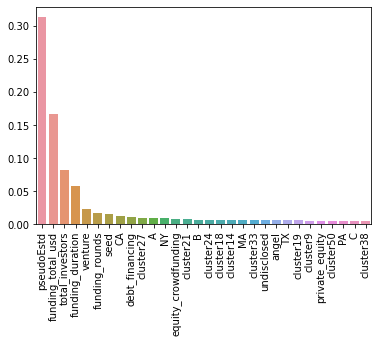

In [62]:
sns.barplot(x=sortedFeatures[:30], y=sortedValue[:30])
plt.xticks(rotation=90)
plt.show()

**Normalization**

In [0]:
from sklearn.preprocessing import MinMaxScaler
#normalization of continuous data
scaler = MinMaxScaler()
normalizedXTrain = scaler.fit_transform(X_combined)
normalizedXTest = scaler.transform(X_test)
#print(normalizedXTrain)

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [15]:
params = {
    'C':[10, 100,150, 200]
}

logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1)
gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1,cv=val_split_balanced,scoring='roc_auc')
gridSearch.fit(normalizedXTrain, y_combined)
print(gridSearch.best_estimator_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.6s finished


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=6,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


In [16]:
lrModel = gridSearch.best_estimator_
gridSearch.best_score_
#dump(lrModel, './model/logisticRegressionModel.joblib')

0.8282665841540977

In [18]:
lrTestPredict = lrModel.predict(normalizedXTest)
lrTestScore = accuracy_score(y_test, lrTestPredict)
print("the accuracy score for testing set : {}".format(lrTestScore))
print("The macro f1 score for logistic regression",f1_score(y_test,lrTestPredict,average='macro'))


the accuracy score for testing set : 0.7718388512165936
The macro f1 score for logistic regression 0.6595762572378749



Confusion matrix for  LR classifier


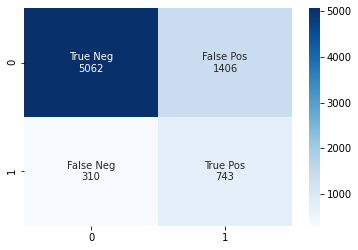

In [19]:
cnf_matrix = confusion_matrix(y_test, lrTestPredict)
print('\nConfusion matrix for  LR classifier')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')


In [20]:
print('Classification Report for lr class')
lrReport = classification_report(y_test,lrTestPredict)
print(lrReport)

Classification Report for lr class
              precision    recall  f1-score   support

           0       0.94      0.78      0.86      6468
           1       0.35      0.71      0.46      1053

    accuracy                           0.77      7521
   macro avg       0.64      0.74      0.66      7521
weighted avg       0.86      0.77      0.80      7521



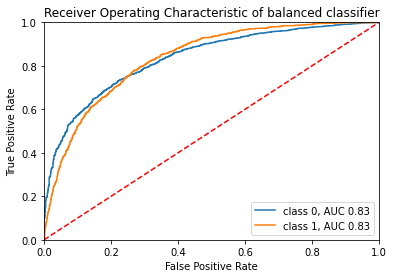

In [21]:
probs = lrModel.predict_proba(normalizedXTest)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [0]:
from collections import OrderedDict
posEg = OrderedDict()
negEg = OrderedDict()
indicesForPosEg = np.argsort(-1*lrModel.coef_)[:,0:30][0]
for i in indicesForPosEg[0:30]:
    posEg[features.columns.values[i]] = lrModel.coef_[0,i]
indicesForNegEg = np.argsort(lrModel.coef_)[:,0:30][0]
for i  in indicesForNegEg[0:30]:
    negEg[features.columns.values[i]] = -1*lrModel.coef_[0,i]

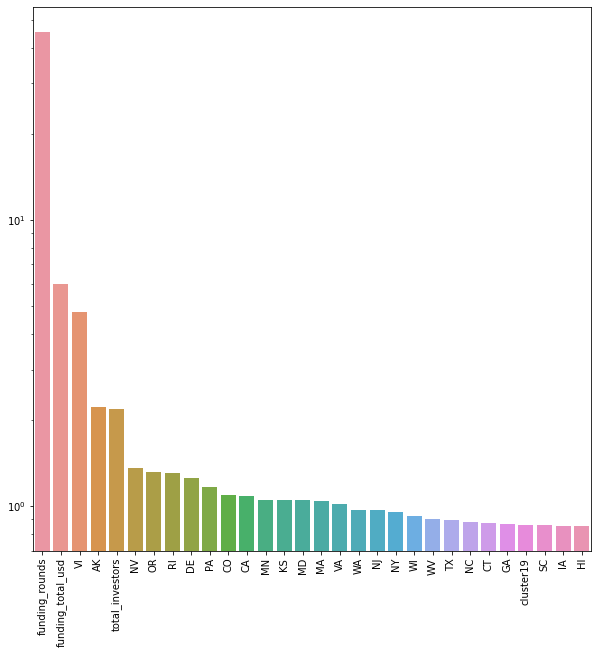

In [261]:
fig, ax = plt.subplots(figsize=(10,10))
x=list(posEg.keys())

y = list(posEg.values())

sns.barplot(x=x, y=y,orient='v')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

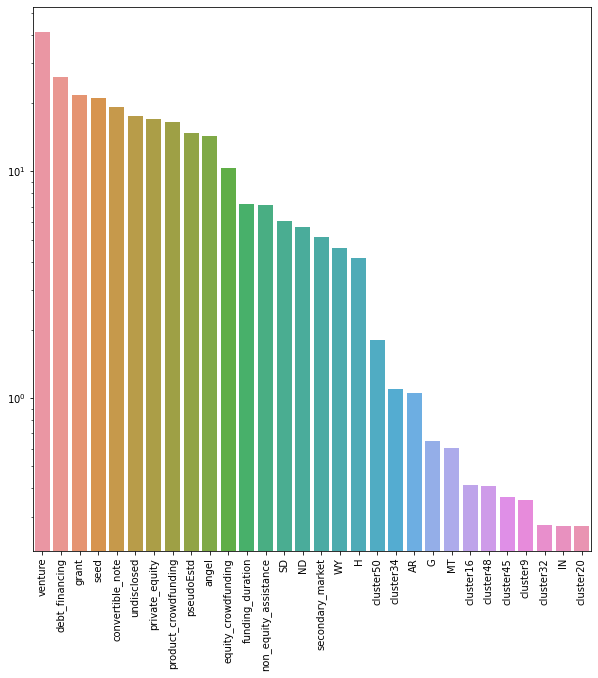

In [262]:
fig, ax = plt.subplots(figsize=(10,10))
x=list(negEg.keys())

y = list(negEg.values())

sns.barplot(x=x, y=y,orient='v')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    y_pred = y_pred[:,1]
    y_true = y_true[:,1]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_pred = y_pred[:,1]
    y_true = y_true[:,1]
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    #y_pred = y_pred[:,1]
    #y_true = y_true[:,1]
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Multilayer Perceptron

In [0]:
def funcBaseModel(shape):

  inputLayer = Input(shape=(shape,))
  hiddenLayer1 = Dense(256, activation='relu')(inputLayer)
  hiddenLayer1 = Dropout(0.5)(hiddenLayer1)
  # hiddenLayer2 = Dense(128, activation='relu')(hiddenLayer1)
  # hiddenLayer2 = Dropout(0.3)(hiddenLayer2)
  hiddenLayer3 = Dense(128, activation='relu')(hiddenLayer1)
  hiddenLayer3 = Dropout(0.5)(hiddenLayer3)
  hiddenLayer4 = Dense(32, activation='relu')(hiddenLayer3)
  hiddenLayer4 = Dropout(0.2)(hiddenLayer4)
  outputLayer = Dense(2, activation='softmax')(hiddenLayer4)
  #sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  funcModel = Model(inputs = inputLayer, outputs = outputLayer)
  funcModel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['acc', precision_m, recall_m, f1_m])
  return funcModel

In [203]:
model = funcBaseModel(129)
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 129)]             0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               33280     
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_40 (Dropout)         (None, 32)                0  

In [0]:
from sklearn.preprocessing import MinMaxScaler
#normalization of continuous data
scaler = MinMaxScaler()
normalizedXTrain = scaler.fit_transform(XTrain)
normalizedXTest = scaler.transform(X_test)
y_trainEncoded = to_categorical(yTrain, 2)
y_testEncoded = to_categorical(y_test,2)

In [205]:

model.fit(normalizedXTrain, y_trainEncoded, batch_size=64, epochs=30, validation_data=(normalizedXTest, y_testEncoded))

Epoch 1/30
809/809 [==============================] - 4s 5ms/step - loss: 0.5998 - acc: 0.6736 - precision_m: 0.6611 - recall_m: 0.7052 - f1_m: 0.6772 - val_loss: 0.5947 - val_acc: 0.6519 - val_precision_m: 0.2535 - val_recall_m: 0.7735 - val_f1_m: 0.3755
Epoch 2/30
809/809 [==============================] - 4s 5ms/step - loss: 0.5451 - acc: 0.7252 - precision_m: 0.7089 - recall_m: 0.7676 - f1_m: 0.7330 - val_loss: 0.5440 - val_acc: 0.7028 - val_precision_m: 0.2821 - val_recall_m: 0.7186 - val_f1_m: 0.3967
Epoch 3/30
809/809 [==============================] - 4s 5ms/step - loss: 0.5205 - acc: 0.7405 - precision_m: 0.7206 - recall_m: 0.7879 - f1_m: 0.7492 - val_loss: 0.5156 - val_acc: 0.7011 - val_precision_m: 0.2809 - val_recall_m: 0.7239 - val_f1_m: 0.3971
Epoch 4/30
809/809 [==============================] - 4s 5ms/step - loss: 0.5027 - acc: 0.7530 - precision_m: 0.7315 - recall_m: 0.8030 - f1_m: 0.7621 - val_loss: 0.5159 - val_acc: 0.7149 - val_precision_m: 0.2879 - val_recall_m: 0.

In [206]:
modelPrediction = (model.predict(normalizedXTest)>.5).astype('int')
score = accuracy_score(y_test, modelPrediction[:,1])
print(score)

0.7647919159686212



Confusion matrix for  MLP


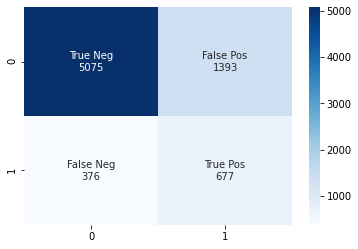

In [208]:
#print(confusion_matrix(y_test, modelPrediction))
cnf_matrix = confusion_matrix(y_test, modelPrediction[:,1])
print('\nConfusion matrix for  MLP')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')


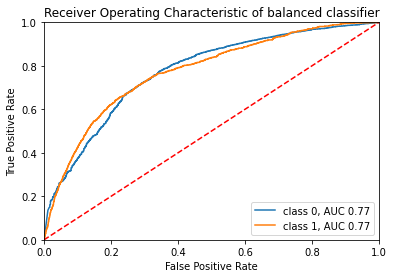

In [209]:
probs = model.predict(normalizedXTest)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [210]:
print(classification_report(y_test, modelPrediction[:,1]))


              precision    recall  f1-score   support

           0       0.93      0.78      0.85      6468
           1       0.33      0.64      0.43      1053

    accuracy                           0.76      7521
   macro avg       0.63      0.71      0.64      7521
weighted avg       0.85      0.76      0.79      7521



## ResNet

In [0]:
def resNetSkips(numOfSkip, inputBlock, nodes=128, dropOut=0.5):
  if numOfSkip == 1:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock

  if numOfSkip == 2:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock
  
  if numOfSkip == 3:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock

def getResNetModel(inputShape, residualBlockDepths, skipConnection, numNodes=128, learningRate=0.001, dropOut=0.5):
  inputs = Input(shape=(inputShape,), name='img')
  resNetwork = Dense(numNodes, activation='relu')(inputs)
  blockOutput = Dense(numNodes, activation='relu')(resNetwork)

  for i in range(residualBlockDepths):
    blockOutput = resNetSkips(skipConnection, blockOutput, numNodes, dropOut)

  
  resNetwork = Dense(numNodes, activation='relu')(blockOutput)
  resNetwork = Dropout(dropOut)(resNetwork)
  outputs = Dense(2, activation='softmax')(resNetwork)

  resNetworkModel = tf.keras.Model(inputs = inputs, outputs = outputs, name='resnetwork')
  resNetworkModel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
  return resNetworkModel
  

In [214]:
resNetModel = getResNetModel(129, 3, 2, 256, 0.5)
resNetModel.summary()

Model: "resnetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 129)]        0                                            
__________________________________________________________________________________________________
dense_88 (Dense)                (None, 256)          33280       img[0][0]                        
__________________________________________________________________________________________________
dense_89 (Dense)                (None, 256)          65792       dense_88[0][0]                   
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 256)          65792       dense_89[0][0]                   
_________________________________________________________________________________________

In [215]:
resNetModel.fit(normalizedXTrain, y_trainEncoded, batch_size=64, epochs=30, validation_data=(normalizedXTest, y_testEncoded))

Epoch 1/30
809/809 [==============================] - 9s 11ms/step - loss: 0.6981 - acc: 0.6699 - f1_m: 0.6716 - precision_m: 0.6642 - recall_m: 0.6893 - val_loss: 0.4665 - val_acc: 0.7603 - val_f1_m: 0.4111 - val_precision_m: 0.3167 - val_recall_m: 0.6222
Epoch 2/30
809/809 [==============================] - 8s 10ms/step - loss: 0.5210 - acc: 0.7432 - f1_m: 0.7543 - precision_m: 0.7214 - recall_m: 0.7998 - val_loss: 0.5392 - val_acc: 0.7195 - val_f1_m: 0.4121 - val_precision_m: 0.2956 - val_recall_m: 0.7238
Epoch 3/30
809/809 [==============================] - 8s 10ms/step - loss: 0.4925 - acc: 0.7627 - f1_m: 0.7736 - precision_m: 0.7375 - recall_m: 0.8229 - val_loss: 0.5753 - val_acc: 0.6930 - val_f1_m: 0.4043 - val_precision_m: 0.2816 - val_recall_m: 0.7621
Epoch 4/30
809/809 [==============================] - 8s 10ms/step - loss: 0.4644 - acc: 0.7818 - f1_m: 0.7923 - precision_m: 0.7530 - recall_m: 0.8448 - val_loss: 0.4858 - val_acc: 0.7385 - val_f1_m: 0.4178 - val_precision_m: 0.

In [220]:
resnetModelPrediction = (resNetModel.predict(normalizedXTest)>0.5).astype('int')
score = accuracy_score(y_test, resnetModelPrediction[:,1])
print(score)

0.7868634490094403



Confusion matrix for  ResNet


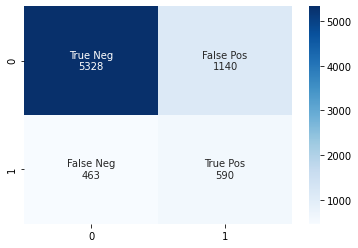

In [221]:
cnf_matrix = confusion_matrix(y_test, resnetModelPrediction[:,1])
print('\nConfusion matrix for  ResNet')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

In [223]:
print(classification_report(y_test, resnetModelPrediction[:,1]))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      6468
           1       0.34      0.56      0.42      1053

    accuracy                           0.79      7521
   macro avg       0.63      0.69      0.65      7521
weighted avg       0.84      0.79      0.81      7521



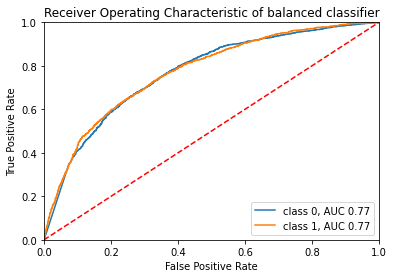

In [225]:
probs = resNetModel.predict(normalizedXTest)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()